In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
sns.set()

# 1. Download UCDP Conflict Data
`http://ucdp.uu.se/downloads/ged/ged201-xlsx.zip`

- Build your curated database from the UCDP raw data where you find all events occurred in Afghanistan, specifically for three districts called Kunduz, Ghazni, and Kabul
- In your database, you want to curate monthly total number of events and total number of people affected (use column name “BEST” in the raw data)
- Plot your time-series data where x-axis refers to time (year-month) and y-axis refers to total number of people affected for each of districts (Kunduz, Ghazni, and Kabul)

## 1.1 Assumptions
1. Get year-month from the `date_start` column
  - There are 4 data rows where the year data in `year` column is different from the year data in `date_start` (See below)
  - We assume the data error and use the year data of the `date_start` column
  
  
2. Get the districts (Kunduz, Ghazni, and Kabul) from the columns: `where_coordinates`, `where_description`, `adm_1`
  - If the name of the district appears in at least one of these 3 columns, use that data
  - For example, if `where_description` = 'Nangarhar, Kapisa, Khost, Ghazni, Logar, Kandahar, Uruzgan, **Kunduz**, Faryab, Balkh, Baghlan, Badakhshan and Helmand provinces', that data row will be included in one of the **Kunduz** event

In [192]:
excel_file = 'data/ged/ged201.xlsx'

df = pd.read_excel(excel_file, usecols='C,Z:AB,AH,AM,AS')

In [193]:
df.head()

,year,where_coordinates,where_description,adm_1,country,date_start,best
0,2017,Kabul city,Iraqi embassy in Kabul,Kabul province,Afghanistan,2017-07-31,6
1,1989,Nangarhar province,Nangarhar province,Nangarhar province,Afghanistan,1989-01-07,6
2,1989,Kunduz province,Kunduz province,Kunduz province,Afghanistan,1989-01-15,4
3,1989,Salang pass,Salang pass (on the main highway linking Kabul...,Baghlan province,Afghanistan,1989-01-23,600
4,1989,Kabul city,Kabul city,Kabul province,Afghanistan,1989-01-30,2


### 1.1.1 The data where the year in `year` column is different from the year in `date_start`
- We assume the data error and use the year data of the `date_start` column

In [198]:
df[df['date_start'].dt.year != df['year']]

,year,where_coordinates,where_description,adm_1,country,date_start,best
58799,2017,Central Sinai governorate,central Sinai,Central Sinai governorate,Egypt,2018-01-01,2
59076,1989,Usulután department,NaN,Usulután department,El Salvador,1990-11-26,1
59960,2013,Kebridehar woreda,"Kabosiciid area, Qabridehar district, Qorahay ...",Somali state,Ethiopia,2014-11-24,0
85177,1996,Northern Iraq,northern Iraq,NaN,Iraq,1997-01-01,154


### 1.1.2 Create Filter for Kunduz, Ghazni, and Kabul events

In [199]:
country_filter = (df['country']=='Afghanistan')

kunduz_filter = df['where_coordinates'].str.contains('kunduz', case=False) \
                | df['where_description'].str.contains('kunduz', case=False) \
                | df['adm_1'].str.contains('kunduz', case=False)

ghazni_filter = df['where_coordinates'].str.contains('ghazni', case=False) \
                | df['where_description'].str.contains('ghazni', case=False) \
                | df['adm_1'].str.contains('ghazni', case=False)

kabul_filter = df['where_coordinates'].str.contains('kabul', case=False) \
                | df['where_description'].str.contains('kabul', case=False) \
                | df['adm_1'].str.contains('kabul', case=False)

In [200]:
kunduz_df = df[country_filter & kunduz_filter]

ghazni_df = df[country_filter & ghazni_filter]

kabul_df = df[country_filter & kabul_filter]

# 1.2 Curate monthly total number of events and total number of people affected 
- Create a helper function `get_event_df` to curate the required data 

In [202]:
def get_event_df(df):
    
    df = df[['date_start', 'best']]
    df = df[df['best'] != 0]
    df.set_index('date_start', inplace=True)

    df_sum = df.resample('M').sum()
    df_sum = df_sum.rename(columns={'best': 'event_sum'})

    df_count = df.resample('M').count()
    df_count = df_count.rename(columns={'best': 'event_count'})

    return df_sum.join(df_count)

In [203]:
kd = get_event_df(kunduz_df)
gn = get_event_df(ghazni_df)
kb = get_event_df(kabul_df)

In [204]:
kd.head()

,event_sum,event_count
date_start,,
1989-01-31,4,1
1989-02-28,0,0
1989-03-31,0,0
1989-04-30,0,0
1989-05-31,0,0


In [205]:
gn.head()

,event_sum,event_count
date_start,,
1989-02-28,6,1
1989-03-31,0,0
1989-04-30,0,0
1989-05-31,0,0
1989-06-30,0,0


In [206]:
kb.head()

,event_sum,event_count
date_start,,
1989-01-31,602,2
1989-02-28,34,7
1989-03-31,289,5
1989-04-30,67,10
1989-05-31,18,2


# 1.3 Plot time-series data
- x-axis refers to time (year-month)
- y-axis refers to total number of people affected for each of districts (Kunduz, Ghazni, and Kabul)


- Per instruction, plot only total number of people affected and set x-axis to 'year-month' 

### 1.3.1 Plot of total number of people affected in Kunduz district, Afghanistan

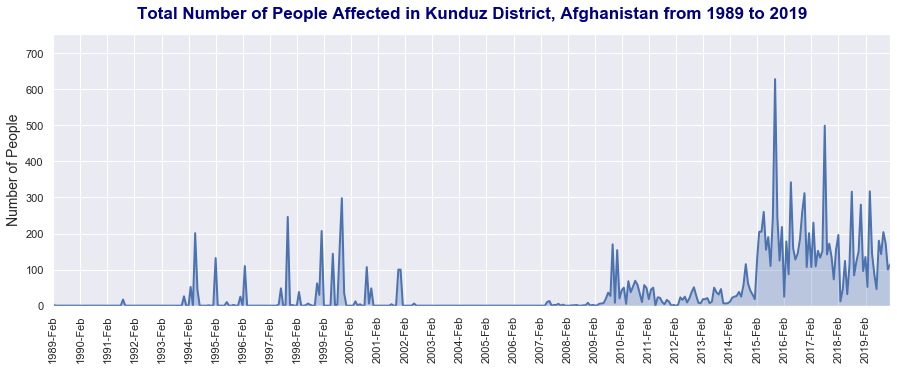

In [213]:
xdata = kd['event_sum'].index
ydata = kd['event_sum'].tolist()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(xdata, ydata, lw=2)
ax.fill_between(xdata, 0, ydata, alpha=0.3)
ax.set(xlim=(xdata[0],xdata[-1]))
ax.set(ylim=(0,max(ydata)*1.2))

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)

ylabel = ax.set_ylabel('Number of People')
ylabel.set_size(14)

ttl = ax.set_title('Total Number of People Affected in Kunduz District, Afghanistan from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

### 1.3.2 Plot of total number of people affected in Ghazni district, Afghanistan

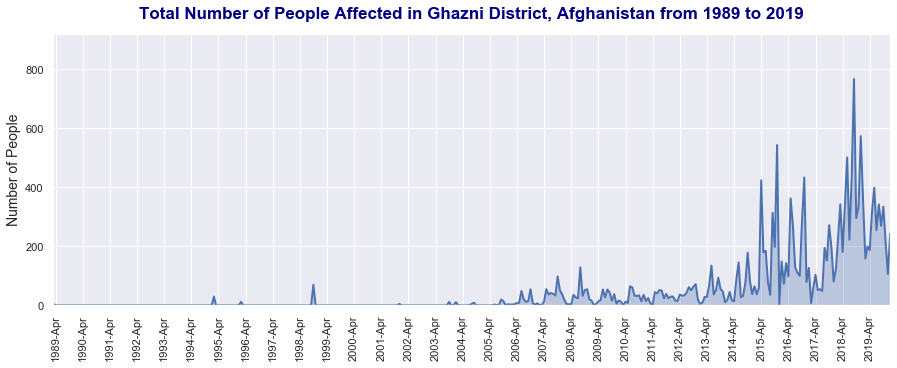

In [212]:
xdata = gn['event_sum'].index
ydata = gn['event_sum'].tolist()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(xdata, ydata, lw=2)
ax.fill_between(xdata, 0, ydata, alpha=0.3)
ax.set(xlim=(xdata[0],xdata[-1]))
ax.set(ylim=(0,max(ydata)*1.2))

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)

ylabel = ax.set_ylabel('Number of People')
ylabel.set_size(14)

ttl = ax.set_title('Total Number of People Affected in Ghazni District, Afghanistan from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

### 1.3.3 Plot of total number of people affected in Kabul district, Afghanistan

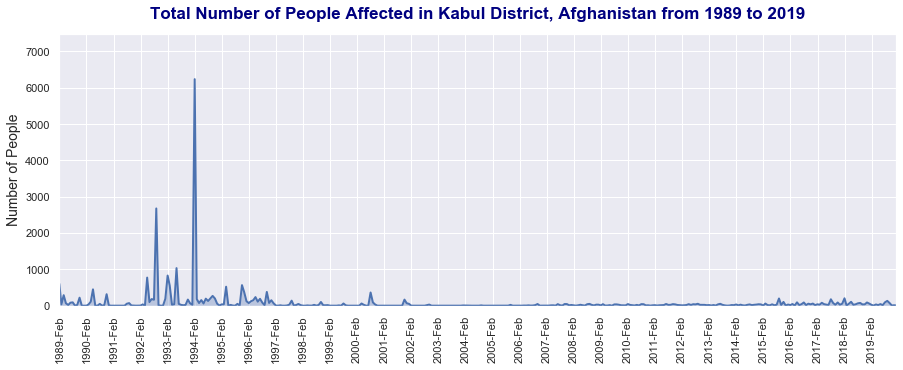

In [211]:
xdata = kb['event_sum'].index
ydata = kb['event_sum'].tolist()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(xdata, ydata, lw=2)
ax.fill_between(xdata, 0, ydata, alpha=0.3)
ax.set(xlim=(xdata[0],xdata[-1]))
ax.set(ylim=(0,max(ydata)*1.2))

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)

ylabel = ax.set_ylabel('Number of People')
ylabel.set_size(14)

ttl = ax.set_title('Total Number of People Affected in Kabul District, Afghanistan from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17)

## 1.4 Export DataFrame

In [210]:
kd.to_csv('exported_df/kunduz.csv')
gn.to_csv('exported_df/ghazni.csv')
kb.to_csv('exported_df/kabul.csv')